In [7]:
!pip3 install YahooFinancials
!pip3 install pytrends
!pip3 install statsmodels


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no lon

In [25]:
from datetime import datetime, timedelta

#from statsmodels.tsa.seasonal import STL
import pandas as pd
from pytrends.request import TrendReq
import pytrends
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import numpy as np
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

##  COLLECT DATA

In [9]:
url = 'https://raw.githubusercontent.com/puchee99/TimeSeriesDL/main/pytrends_data.csv'
url_test = 'https://raw.githubusercontent.com/puchee99/TimeSeriesDL/test/test_yahoo.csv'

df = pd.read_csv(url)
df_test = pd.read_csv(url_test)
#df1 = df.asfreq(pd.infer_freq(df.index))
df

,date,Bitcoin,Tesla,Apple,Gold,Oil,stock,call,put,stock up,...,Gold%,Oil%,stock%,call%,put%,stock up%,stock down%,bear market%,bull market%,recession%
0,2017-04-21,2,3,22,20,17,43,61,27,25,...,5.363158,0.100000,-4.344444,11.009091,3.946154,4.266667,30.100000,-28.471429,-24.900000,14.683333
1,2017-04-22,1,3,24,20,17,22,59,27,21,...,0.100000,0.100000,-48.737209,-3.178689,0.100000,-15.900000,-61.438462,20.100000,0.100000,-32.627273
2,2017-04-23,1,2,23,20,17,20,51,27,13,...,0.100000,0.100000,-8.990909,-13.459322,0.100000,-37.995238,20.100000,0.100000,16.766667,10.910811
3,2017-04-24,1,3,22,19,17,44,56,26,26,...,-4.900000,0.100000,120.100000,9.903922,-3.603704,100.100000,50.100000,33.433333,42.957143,44.002439
4,2017-04-25,2,3,23,19,17,50,60,26,31,...,0.100000,0.100000,13.736364,7.242857,0.100000,19.330769,11.211111,12.600000,-29.900000,10.269492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2022-05-13,28,12,38,39,29,76,41,25,18,...,2.731579,0.100000,-7.217073,0.100000,0.100000,-5.163158,-37.995238,-21.639130,0.100000,-45.900000
1891,2022-05-14,20,9,41,41,31,33,39,27,12,...,5.228205,6.996552,-56.478947,-4.778049,8.100000,-33.233333,-38.361538,-33.233333,-28.471429,-12.862963
1892,2022-05-15,17,8,41,38,29,27,38,28,10,...,-7.217073,-6.351613,-18.081818,-2.464103,3.803704,-16.566667,-49.900000,-24.900000,0.100000,-6.282979
1893,2022-05-16,18,11,37,39,28,64,39,26,13,...,2.731579,-3.348276,137.137037,2.731579,-7.042857,30.100000,175.100000,22.322222,20.100000,86.463636


## EDA

In [10]:
df.isnull().sum().sum()

0

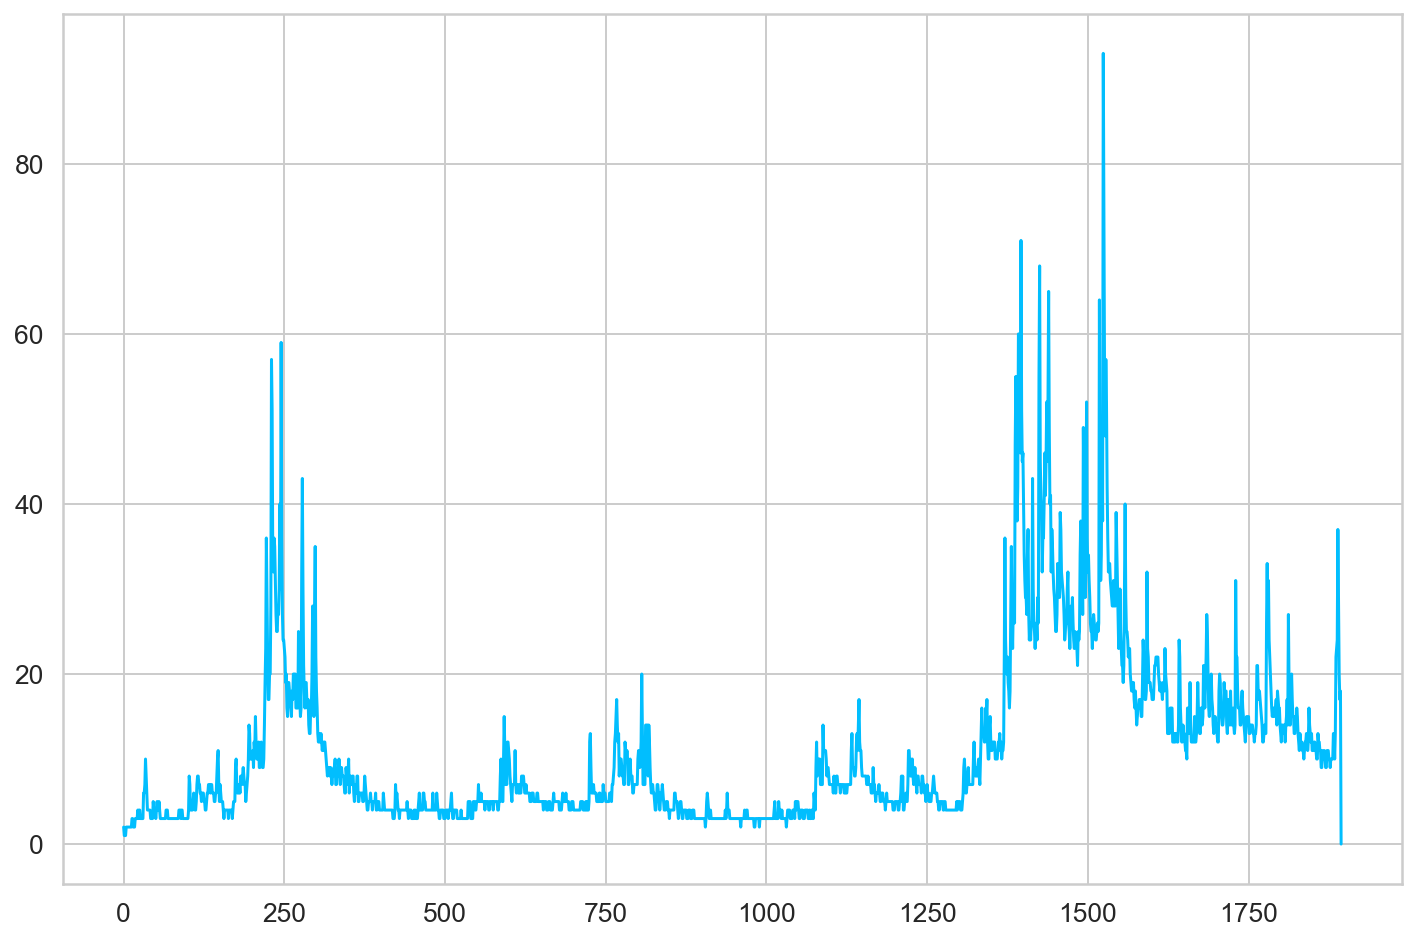

In [11]:
dfBTC = df['Bitcoin']
plt.plot(dfBTC)

## TRAIN MODEL

In [17]:
df = df_test.set_index("formatted_date")
df

,Unnamed: 0,date_BTC-USD,high_BTC-USD,low_BTC-USD,open_BTC-USD,close_BTC-USD,volume_BTC-USD,adjclose_BTC-USD,BTC-USD%,BTC-USD_Y,BTC-USD_Vol,BTC-USD_YPred
formatted_date,,,,,,,,,,,,
2014-09-17,0,1410912000,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015,-1.831006,0,2.105680e+07,0.0
2014-09-18,1,1410998400,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002,-7.096262,0,3.448320e+07,0.0
2014-09-19,2,1411084800,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990,-6.910351,0,3.791970e+07,4.0
2014-09-20,3,1411171200,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992,3.605767,4,3.686360e+07,0.0
2014-09-21,4,1411257600,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014,-2.270110,0,2.658010e+07,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,2798,1652659200,31305.341797,29251.884766,31304.375000,29862.917969,3.261390e+10,29862.917969,-4.604650,0,3.261390e+10,4.0
2022-05-17,2799,1652745600,30694.490234,29570.302734,29862.408203,30425.857422,2.910147e+10,30425.857422,1.886818,4,2.910147e+10,0.0
2022-05-18,2800,1652832000,30618.716797,28720.271484,30424.478516,28720.271484,3.128527e+10,28720.271484,-5.601434,0,3.128527e+10,2.0


In [27]:
df["BTC-USD%"].values

array([-1.83100616, -7.0962623 , -6.91035127, ..., -5.60143383,
               nan,  0.23503388])

Text(0.5, 1.0, 'Daily cases')

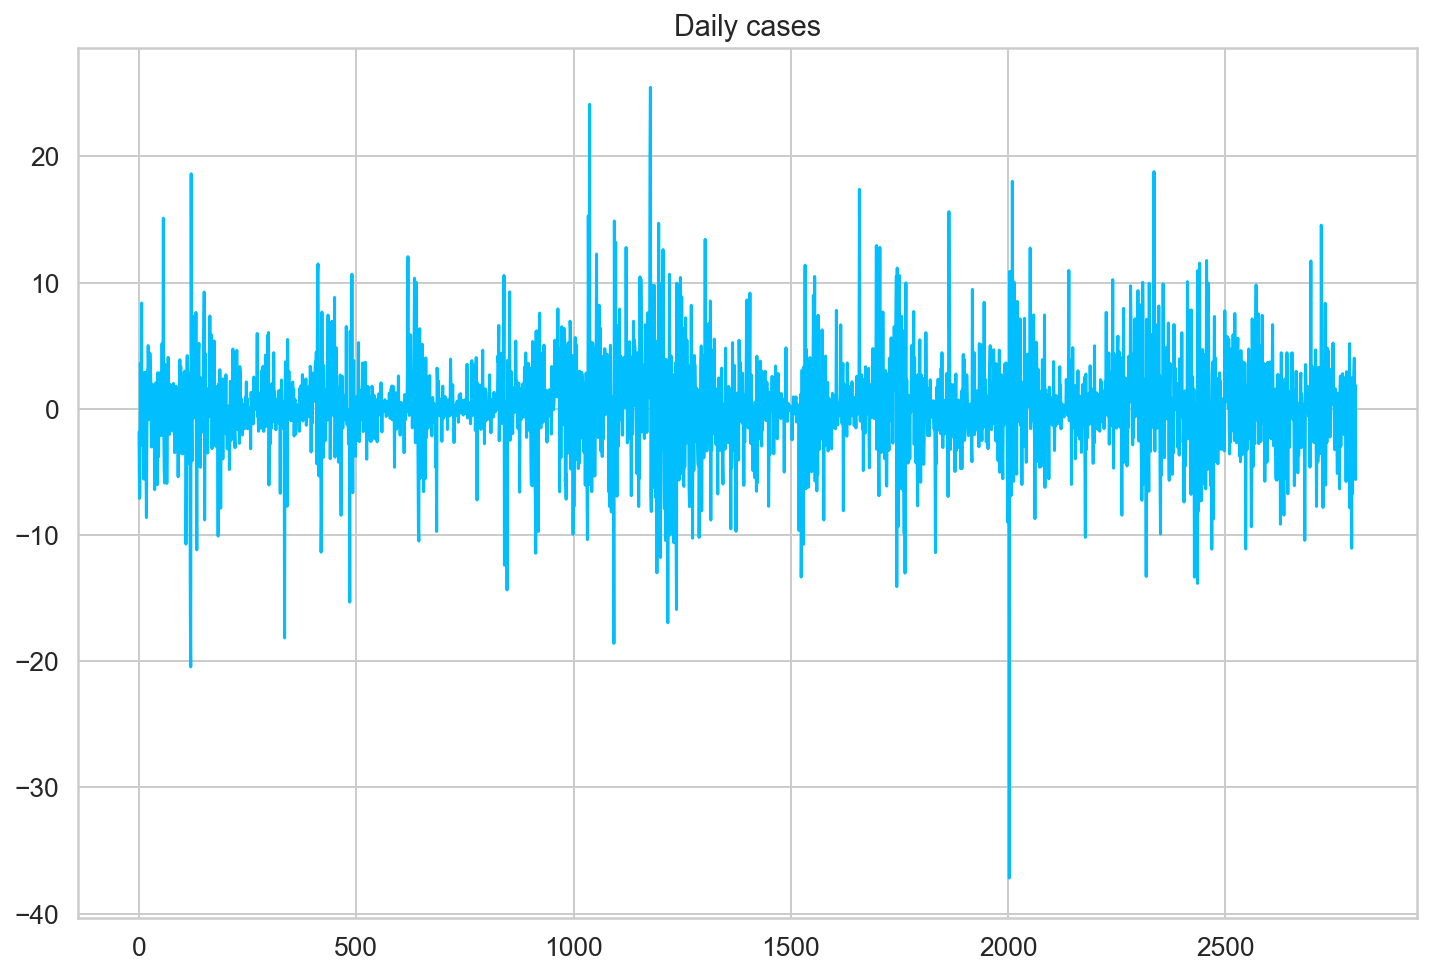

In [28]:
plt.plot(df["BTC-USD%"].values)
plt.title("Daily cases")

In [29]:
daily_change = df["BTC-USD%"].values

test_data_size = 500

train_data = daily_change[:-test_data_size]
test_data = daily_change[-test_data_size:]

train_data.shape

(2303,)

In [30]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [31]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [32]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [33]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [34]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [35]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 786.2789306640625 test loss: nan


KeyboardInterrupt: 

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

## ANOMALY TEST

In [ ]:
df.head()
df.columns
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.target.value_counts()

 0.100000     235
-12.400000     36
 14.385714     29
 20.100000     29
-16.566667     29
             ... 
 46.045946      1
-37.635849      1
 2.273913       1
-2.027660       1
-99.900000      1
Name: target, Length: 570, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


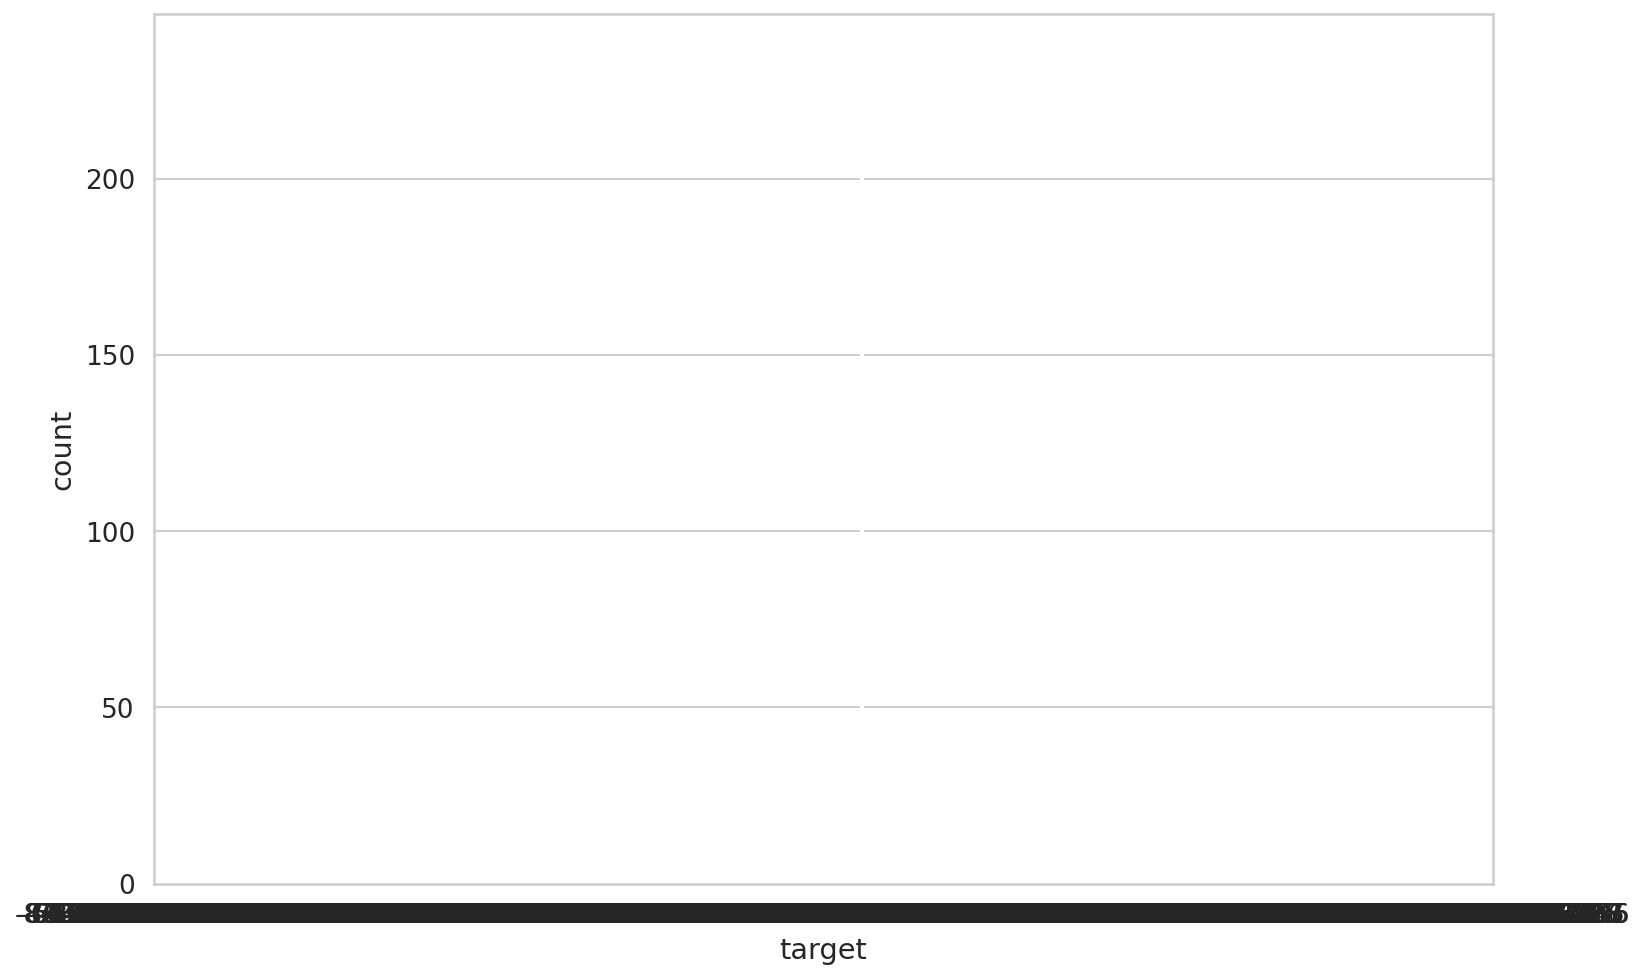

In [ ]:
ax = sns.countplot(df.target)
#ax.set_xticklabels()

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, classes[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  app.launch_new_instance()


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdec761f320> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
train_df, val_df = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## MORE TRY

## STL

In [ ]:
stl = STL(dfBTC)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(dfBTC)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()